## Hello this is the jupyter file that demonstrates how to attain housing market research from towncharts.com for a given list of cities from a state.

Here is a snapshot of the web page for a given city. We will be scraping the pieces of information included in this web page

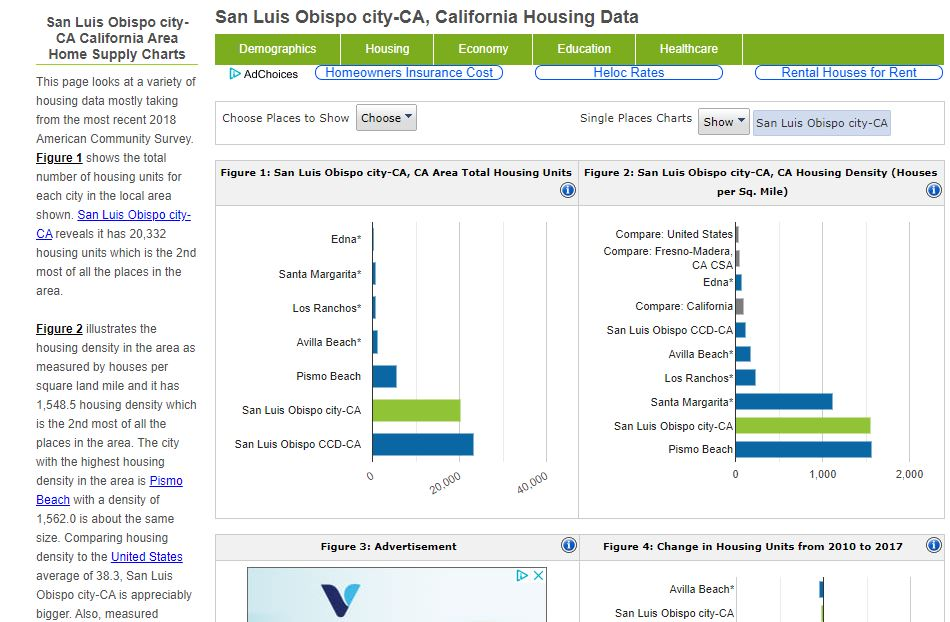

Data dictionary 35 pieces of information: provided by Towncharts.com

* city_name: Name of city
* housing_units:Total number of housing units in the area
* housing_density : The number of housing units per square mile in the area
* change_hunits: Change in housing units from 2010 to 2017
* percent_of_rent_to_total: The percent of all occupied housing units that are rental housing units (%)
* owned_homes: The percent of all occupied housing units that are owned housing units (%)
* med_homeval: Median home value i.e how much property is worth( house and lot, mobile homes and lot, or condominium unit) if it was for sale \$

* med_rental_rate: the median monthly rental amount for a rental unit in this area \$

* med_owner_cost: The monthly cost of housing for property owners including mortgage payment, taxes, insurance,and utilities.\$

* med_own_cost_aspercentof_income: The monthly owner cost as a percent of the household income. This measure is an excellent way to understand how affordable housing is for owners in an area (%)
* med_hval_aspercentof_medearn: How much the property is worth(house and lot, mobile home and lot, or condominium unit) if it was for sale as a percent of the median earnings for a worker in the area (%)
* med_hcost_ownmortg: Median housing cost for homeowners with a mortgage(including the cost of the mortgage or other debt) \$
* med_hcost_own_wo_mortg: Median housing cost for homeowners who do not have a mortgage. This isolates the cost of ownership seperate from the financing cost of debt \$
* hcost_aspercentof_hincome_ownmortg: Homeowners with a mortgage showing total cost (including mortgage debt) as a percent of household income (%)
* hcost_as_perc_of_hincome_womortg: Homeowners without a mortgage showing total cost as a percent of household income.

* med_real_estate_taxes: The median real estate taxes paid by owners of homes in the area\$

* family_members_per_hunit: The average size of related families members who live together in a housing unit. 
* median_num_ofrooms: The average number of rooms of total rooms for housing units in the area
* median_year_house_built: The average year the housing units were built in the area. This indicates the average age of housing units in the area.
* household_size_of_howners: For people who own their homes how many people on average are living in them whether they are part of family or related or not. 
* household_size_for_renters: The average size of a household for people who are renting.
* med_year_moved_in_for_owners: The median year that a home owner moved into their home
* med_year_renter_moved_in: The median year that a renter moved into their home 
* The following varialbes are monthly rental rates by size of  Rental in Bedrooms as a percentage
studio_1000_1499,
studio_1500_more,
studio_750_999,
onebed_1000_1499,
onebed_1500_more,
onebed_750_999,
twobed_1000_1499,
twobed_1500_more,
twobed_750_999,
threebed_1000_1499,
threebed_1500_more,
threebed_750_999

Here are the prerequisite libraries

In [10]:
import requests
import urllib
import re
from bs4 import BeautifulSoup
from googlesearch import search
import pandas as pd
import numpy as np
from fake_useragent import UserAgent
import time
import pickle

We gather our list of cities in California from the Name column in a dataset from Kaggle.com

In [11]:
cities_data = pd.read_csv('C:\\Users\\Crist\\Towncharts\\California_Housing_Project\\datasets\\cal_cities_lat_long.csv')

In [12]:
cities_data.Name.size

458

In [13]:
city_list = cities_data.Name.tolist()

In [14]:
def preprocess_city_list(listofcities):
    """
    
    Args:
            listofcities (list): a case sensitive list of cities with appropriate capitalization
            and spaces for cities with multiple words

    Returns:
            newlist: list of cities with " " replaced with - for google search to work
    """
    list_of_cities = []
    for city in listofcities:
        new = city.replace(' ','-')
        list_of_cities.append(new)
    return list_of_cities

In [15]:
list_of_cities = preprocess_city_list(city_list)

In [16]:
list_of_cities[220:225]

['Livingston', 'Lodi', 'Loma-Linda', 'Lomita', 'Lompoc']

The function below is responsible for finding the url link to scrape the appropriate housing information from towncharts.com

Important to note we are not targeting ccd or cdp designated locations our population of interest does not include them. 

In [17]:
def searchgoogle(nameofstate,stateabbr,list_of_cities):
    """
    Args:
                nameofstate: casesensitive use typical spelling 
                stateabbr: state abbreviation case sensitve must be formated in caps
                listofcities (list): a list of cities for a state with ""-"" between multiple words 
                acceptccd:

    Returns:
                a dictionary with keys 
                theclean: url links for towncharts.com housing data for each city in list of cities inputed to the function
                themissing: unfound google search url links  for towncharts.com housing data for cities in list of cities. 
    """
    #results lists
    clean_links = []
    missing_cities = []
    
    if " " in nameofstate:
        nameofstate = nameofstate.replace(' ', '-')
    
    #begin searching
    for city in list_of_cities:
        backup_url = "https://www.towncharts.com/{}/Housing/{}-city-{}-Housing-data.html".format(nameofstate,city,stateabbr)
        query  = "'https://www.towncharts.com/{}/Housing/{}-city-{}-Housing-data.html'".format(nameofstate,city,stateabbr)
        query = urllib.parse.quote_plus(query) # Format into URL encoding
        number_result = 3
        
        ua = UserAgent()
        
        google_url = "https://www.google.com/search?q=" + query + "&num=" + str(number_result)
        #setting up a delay
        t0 = time.time()
        response = requests.get(google_url, {"User-Agent": ua.random})
        response_delay = time.time() - t0
        time.sleep(10*response_delay)
        soup = BeautifulSoup(response.text, "html.parser")
        
        result_div = soup.find_all('div', attrs = {'class': 'ZINbbc'})
        links = []
        for r in result_div:
            
            try:
                link = r.find('a', href = True)
                if link != '':
                    links.append(link['href'])
            except:
                continue
        flag = True
        for i, l in enumerate(links):
            clean = re.search('\/url\?q\=(.*)\&sa',l)
            if clean is None:
                continue
            #clean.group(1) i.e alink such as https://www.towncharts.com/South-Carolina/Housing/Charleston-city-SC-Housing-data.html    
            elif city in clean.group(1):
                clean_links.append(clean.group(1))
                flag = False
        
        if flag:
            missing_cities.append(city)
            #using our a default formatted url in place as our backup url
            clean_links.append(backup_url)
    return {'thefound':clean_links.copy(),'themissing':missing_cities.copy()}

Lets call the function

In [ ]:
googleresults = searchgoogle('California','CA',list_of_cities)

In [ ]:
# for city in list_of_cities:
#     #only get links for cities not in clean_links
#         backup_url = "https://www.towncharts.com/California/Housing/{}-city-CA-Housing-data.html".format(city)
#         query  = "'https://www.towncharts.com/California/Housing/{}-city-CA-Housing-data.html'".format(city)
#         query = urllib.parse.quote_plus(query) # Format into URL encoding
#         number_result = 3
        
#         ua = UserAgent()
        
#         google_url = "https://www.google.com/search?q=" + query + "&num=" + str(number_result)
#         t0 = time.time()
#         response = requests.get(google_url, {"User-Agent": ua.random})
#         response_delay = time.time() - t0
#         time.sleep(10*response_delay)
#         soup = BeautifulSoup(response.text, "html.parser")
        
#         result_div = soup.find_all('div', attrs = {'class': 'ZINbbc'})
        
#         links = []
#         for r in result_div:
            
#             try:
#                 link = r.find('a', href = True)

#                 if link != '':
#                     links.append(link['href'])
#             except:
#                 continue
#         flag = True
#         for i, l in enumerate(links):
#             clean = re.search('\/url\?q\=(.*)\&sa',l)
#             if clean is None:
#                 continue
#             elif city in clean.group(1):
#                 clean_links.append(clean.group(1))
#                 flag = False
#         if flag:
#             missing_cities.append(city)
#             clean_links.append(backup_url)

Recommended to use the pickle module to save your results from the function above. 
Uncomment the lines below to save the dictionary.

In [ ]:
# outfile = open('my_clean_links','wb')
# pickle.dump(googleresults,outfile)
# outfile.close()

Load the the clean links and missing links

In [18]:
# infile = open('my_clean_links','rb')
# googleresults = pickle.load(infile)
# infile.close()

In [29]:
found_links = googleresults['thefound'].copy()

The found links will not always be necessarily the intended results.

We are going to create a function to clean our Google links since every cities housing data URL for towncharts.com has a consistent format <br> "http://www.towncharts.com/(**nameof state with "-" separating words**)/Housing/(**name of city with "-" separating words**)-city-(**state abbreviation**)-Housing-data.html" since we know this we can create a function to make sure they are in this format for example the City: San Luis Obispo, State:California correct housing data URL is http://www.towncharts.com/California/Housing/San-Luis-Obispo-city-CA-Housing-data.html. We could hardcode this in our function `searchgoogle`  but what if we wanted to actually see the cities Google was unable to find the housing data for and what it returned instead. 

In [19]:
def clean_my_links(found_links,statename,stateabbr):
    """
    args:
            statename: the name of the state with "-" between words
            found_links:a list of google url links for towncharts.com for cities in a certain state
            stateabbr: capitalized state abbreviation
    returns:
            a dictionary: with 
            clean_urls:a list of urls for towncharts.com **housing data** 
            invalid_results: a list of URLs that were not towncharts.com **housing data** or cdp/cdd
    """
    #Making the list of clean_links into a pandas series will help vectorize cleaning our results
    found_links = pd.Series(found_links)
    #drop dupllicates
    city_urls = found_links.drop_duplicates().reset_index(drop=True)
    #list to save which indices
    indexes_to_replace = []
    #finds the urls in which google returned something other than the housing data url
    for i,v in enumerate(city_urls):
        v = pd.Series(v)
        check = v.str.extract('\/{}\/(.*?)\/'.format(statename),expand = False)
        if 'Housing' not in check[0]:
            indexes_to_replace.append(i)
    
    #finds the urls in which google returned the CDP or CDD
  
    for i,v in enumerate(city_urls):
        v=pd.Series(v)
        check = re.findall('City',v[0])
        check2 = re.findall('city',v[0])
        if ( (check == []) & (check2 == []) ):
            indexes_to_replace.append(i)
    print('This the number of city URLs before invalid cities and duplicates: ',len(city_urls))   
    
    invalid_results = city_urls.iloc[indexes_to_replace]
    #Going to find which cities google was not able to find a 
    #suitable url. In effect gathering the city names and indexes 
    #so we may use the backup url in place of the current value (this could be implemented in the gathering of results as well)         
    
    incomplete_urls = city_urls.drop(labels = indexes_to_replace)
    
    #list comprehsion yay!!!
    cities_to_add =[ city for city in list_of_cities if incomplete_urls[incomplete_urls.str.contains(city)].empty ] 

    fill_indexes = [ city_urls[city_urls.str.contains(city)].index[0] for city in cities_to_add]
            
    
    city_urls = city_urls.drop(labels = indexes_to_replace)
    
    #Actually take them out add them where they were and then reset index
    cities_to_fix = pd.Series(cities_to_add,index = fill_indexes)
    
    
    for i,v in cities_to_fix.items():
        city_urls = city_urls.append( pd.Series(["https://www.towncharts.com/{}/Housing/{}-city-{}-Housing-data.html".format(statename,v,stateabbr)],index = [i]) )
        city_urls.reset_index(inplace= True,drop=True)
    
    city_urls = city_urls.drop_duplicates().reset_index(drop=True)
    print('After cleaning this is the number of links for the cities : ' , len(city_urls))

          
          
    return {'clean_urls':city_urls,'invalid_results':invalid_results} 


In [20]:
clean_my_links_results = clean_my_links(found_links,'California','CA')

This the number of city URLs before invalid cities and duplicates:  467
After cleaning this is the number of links for the cities :  458


In [21]:
clean_urls = clean_my_links_results['clean_urls'].copy()

# Lets get scraping 

Now we actually scrape the desired attributes:
<br>
Out of the displayed pieces of information in a housing web page  for a city 
information from the figures: 3,9,13,16,19,20,22,23,25,26,27,31,32,33,34,35,38,39 (18) will not be included due to inconsistencies. Some cities might not have the figure information and an NA will be put in place. 


Below we have three helper functions that help our `get_housing_data`
scraper. Which use [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) and [Regular Expressions](https://docs.python.org/3/howto/regex.html) to make life a lot easier.

In [16]:
def get_text_section(target_section,mysoup):
    """
    Attains the appropriate text section from the **left side bar** for towncharts.com
    each housing data webpage for a city has 4 in total the third being an ad
    Args:
        target_section: div class = 'target_section'
        mysoup: a Beautiful Soup soup object
    Returns: 
        text_section
    """
    found = mysoup.find_all('div',attrs = {'class':target_section})
    validsection = found[0]
    text_section = validsection.find_all(text=True)
    return text_section

In [17]:
def searchpattern(pattern,resultset):
    '''
    Finds regex pattern for a beautiful soup result set
    Args:
        pattern:regex pattern
        resultset: A beautiful soup result set
        
    Returns:
         housing variable of interest type string
    '''
    result = [i for i in resultset if re.search(pattern,i)]
    if result == []:
        result  = None
    elif result !=[]:
        result = (re.findall(pattern,result[0]))[0]
    return result

In [18]:
def refinestring(desiredreplacement,yourstring):
    """
    Replace undesired characters in a string with your choosing
    Args:
        yourstring: a string which you wish to replace certain characters
        desiredreplacement: a dictonary definining your replacement values
    Returns:
        yourstring argument with the desired replacements you request 
    """
    if yourstring  == None:
        return None
    elif yourstring != None:
        rep = dict((re.escape(k),v) for k,v in desiredreplacement.items())
        pattern =re.compile("|".join(rep.keys()))

        return float(pattern.sub(lambda m:rep[re.escape(m.group(0))],yourstring))

#### This is the function that will attempt to gather the housing data variables from towncharts.com for each city URL we pass.  It might take some time for me with my 6GB of ram  it took about 20 min

In [9]:

def get_housing_data(clean_urls,statename,stateabbr):
    """
    Attempts to attain 36 pieces of information from a cities towncharts.com webpage
    Args:
        clean_ulrs: A pandas series or list containing towncharts.com URLs for cities in a state
        statename: case sensitive best practice is proper spelling but with "-" instead of spaces
        stateabbr: all upper case state abbreviation
    Returns:
        A dictionary with two keys 
        'results'- a list where each element is a tuple representing a city with 36 values obtained from towncharts.com
        'not found' -  a list of towncharts.com city urls that where not able to be found
        
    """
    results = []
    not_found = []
    for aurl in clean_urls:
        #to prevent from being blocked 
        ua = UserAgent()
        t0 = time.time()
        response = requests.get(aurl,{"User-Agent": ua.random})

        if response.status_code != 200:
            not_found.append(aurl)
            continue

        response_delay = time.time() - t0
        time.sleep(10*response_delay)

        soup = BeautifulSoup(response.text,'html.parser')
        #The code above parses the HTML (stored in r.text) into a special object 
        #called soup that the Beautiful Soup library understands. 
        #In other words, Beautiful Soup is reading the HTML and making sense of its structure

        housing_text_section1 = get_text_section('section1',soup)
        housing_text_section2 = get_text_section('section2',soup)
        housing_text_section3 = get_text_section('section4',soup)

        #everything below gathers the variables
        if re.search('(.*)\s{}'.format(statename),housing_text_section1[0]) == None:
            city_name = (pd.Series(aurl)).str.extract('Housing\/(.*?)-CA'.format())
        elif re.search('(.*)\s{}'.format(statename),housing_text_section1[0]) != None:
            city_name = re.search('(.*)\sCalifornia'.format,housing_text_section1[0]).group(1)

        #for variables need to remove everything but numbers
        #figure1 
        housing_units = searchpattern('it\shas\s(\d.*?\d)\shousing\sunits\s',housing_text_section1)
        housing_units = refinestring({"$":"",",":"","%":""},housing_units)


        #figure2 
        housing_density = searchpattern('it\shas\s(\d.*?\d)\shousing\sdensity\s',housing_text_section1)
        housing_density = refinestring({"$":"",",":"","%":""},housing_density)

        #figure4 
        change_hunits = searchpattern('it\shas\s(.*?%)\schange\sin\s',housing_text_section1)
        change_hunits = refinestring({"$":"",",":"","%":""},change_hunits)

        #figure5
        percent_of_rent_to_total = searchpattern('it\shas\s(\d.*?%)\sRenter\sPercent\s',housing_text_section1)
        percent_of_rent_to_total = refinestring({"$":"",",":"","%":""},percent_of_rent_to_total)


        #figure 6
        owned_homes = searchpattern('it\shas\s(\d.*?%)\sOwner\sPercent\s',housing_text_section1)
        owned_homes = refinestring({"$":"",",":"","%":""},owned_homes)

        #figure 7 median home value (unique character  = $-numbers-commas)
        med_homeval = searchpattern('it\shas\s(.*?\d)\smedian\shome\svalue\s',housing_text_section2)
        med_homeval = refinestring({"$":"",",":"","%":""},med_homeval)

        #figure 8 median rental rate
        med_rental_rate = searchpattern('it\shas\s(.*?\d)\srental\srates\s',housing_text_section2)
        med_rental_rate = refinestring({"$":"",",":"","%":""},med_rental_rate)

        #figure 10 median owner costs
        med_owner_cost = searchpattern("it\shas\s(.*?\d)\smedian\sownership\scost\s",housing_text_section2)
        med_owner_cost = refinestring({"$":"",",":"","%":""},med_owner_cost)

        #figure 11
        med_own_cost_aspercentof_income = searchpattern('median\sowner\scost\sas\sa\spercent\sof\stotal\shousehold\sincome\sand\sit\shas\s(\d.*?%)',housing_text_section2)
        med_own_cost_aspercentof_income = refinestring({"$":"",",":"","%":""},med_own_cost_aspercentof_income)


        #figure 12 median home value as a percent of a median workers earnings
        med_hval_aspercentof_medearn = searchpattern("it\shas\s(\d.*?%)\smedian\shome\svalue\sas\s",housing_text_section2)
        med_hval_aspercentof_medearn = refinestring({"$":"",",":"","%":""},med_hval_aspercentof_medearn)


        #figure14
        med_hcost_ownmortg = searchpattern('depicts.*\$(.*?\d)\smedian',housing_text_section2)
        med_hcost_ownmortg = refinestring({"$":"",",":"","%":""},med_hcost_ownmortg)


        #figure 15
        med_hcost_own_wo_mortg = searchpattern('are.*\$(.*?\d)\smedian\shousing\s',housing_text_section2)
        med_hcost_own_wo_mortg = refinestring({"$":"",",":"","%":""},med_hcost_own_wo_mortg)

        #figure 17
        hcost_aspercentof_hincome_ownmortg= refinestring({"$":"",",":"","%":""},searchpattern('with\smortgages.*\s(\d.*?%)\scost',housing_text_section2))



        #figure18
        hcost_as_perc_of_hincome_womortg = refinestring({"$":"",",":"","%":""},searchpattern('This\sanalysis.*\s(\d.*?%)\scost',housing_text_section2))


        #figure 21 **
        med_real_estate_taxes = refinestring({"$":"",",":"","%":""},searchpattern('it\shas\s(.*?\d)\smedian\sreal\sestate\s',housing_text_section2))
        

        #figure 28 format 3.0
        family_members_per_hunit = refinestring({"$":"",",":"","%":""},searchpattern('it\shas\s(.*?\d)\sfamily\smembers\sper\s',housing_text_section3))


        #figure 29 4.5
        median_num_ofrooms = refinestring({"$":"",",":"","%":""},searchpattern('it\shas\s(.*?\d)\saverage\snumber\sof\s',housing_text_section3))


        #figure 30
        median_year_house_built = refinestring({"$":"",",":"","%":""},searchpattern('it\shas\s(.*?\d)\syear\sbuilt\swhich\s',housing_text_section3))


        #figure 36
        household_size_of_howners = refinestring({"$":"",",":"","%":""},searchpattern('it\shas\s(.*?\d)\shomeowner\shousehold\ssize\s',housing_text_section3))


        #figure 37
        household_size_for_renters = refinestring({"$":"",",":"","%":""},searchpattern('it\shas\s(.*?\d)\srenter\shousehold\ssize\s',housing_text_section3))
        #figure 40
        med_year_moved_in_for_owners = refinestring({"$":"",",":"","%":""},searchpattern('it\shas\s(.*?\d)\smedian\syear\sthat\sa\shome',housing_text_section3))
        #figure41
        med_year_renter_moved_in = refinestring({"$":"",",":"","%":""},searchpattern('it\shas\s(.*?\d)\smedian\syear\sthat\sa\srenter',housing_text_section3))

        ##figure 24 biggie see below scraping the table

        javascript = soup.find_all('script',attrs = {'type':'text/javascript'})
        need = javascript[4]
        needtext = str(need.find_all(text=True))
        

        if re.search('data24\s\=\sgoogle\.visualization\.arrayToDataTable\((.*?)\);',needtext) == None:
            # i.e. the webpage does not have figure 24
            studio_1000_1499 = None
            onebed_1000_1499 = None
            twobed_1000_1499 = None
            threebed_1000_1499 = None
            studio_1500_more = None
            onebed_1500_more = None
            twobed_1500_more = None
            threebed_1500_more = None
            studio_750_999 = None
            onebed_750_999 = None
            twobed_750_999 = None
            threebed_750_999 = None
        elif re.search('data24\s\=\sgoogle\.visualization\.arrayToDataTable\((.*?)\);',needtext) != None:

            fig24 = re.search('data24\s\=\sgoogle\.visualization\.arrayToDataTable\((.*?)\);',needtext).group(1)
            list_strs = re.findall(r'\[(.*?)\]',fig24)
            
            
            #gathering the variables in the table
            check1 = True
            check2 = True
            check3 = True
            for i,v in enumerate(list_strs):
                if '$1,000 to $1,499' in v:
                    check1 = False
                    val1 = re.findall('v\:(.*?\d),',v)
                    studio_1000_1499 = float(val1[0])
                    onebed_1000_1499 = float(val1[1])
                    twobed_1000_1499 = float(val1[2])
                    threebed_1000_1499 = float(val1[3])
                elif '$1,500 or more' in v:
                    check2 = False
                    val2 = re.findall('v\:(.*?\d),',v)
                    studio_1500_more = float(val2[0])
                    onebed_1500_more = float(val2[1])
                    twobed_1500_more = float(val2[2])
                    threebed_1500_more = float(val2[3])
                elif '$750 to $999' in v:
                    check3 = False
                    val3 = re.findall('v\:(.*?\d),',v)
                    studio_750_999 = float(val3[0])
                    onebed_750_999 = float(val3[1])
                    twobed_750_999 = float(val3[2])
                    threebed_750_999 = float(val3[3])

            if check1:
                studio_1000_1499 = None
                onebed_1000_1499 = None
                twobed_1000_1499 = None
                threebed_1000_1499 = None

            if check2:
                studio_1500_more = None
                onebed_1500_more = None
                twobed_1500_more = None
                threebed_1500_more = None

            if check3:
                studio_750_999 = None
                onebed_750_999 = None
                twobed_750_999 = None
                threebed_750_999 = None

        results.append((city_name,housing_units,housing_density,change_hunits,percent_of_rent_to_total,owned_homes,
               med_homeval,med_rental_rate,med_owner_cost,med_own_cost_aspercentof_income,med_hval_aspercentof_medearn,
              med_hcost_ownmortg,med_hcost_own_wo_mortg,hcost_aspercentof_hincome_ownmortg,hcost_as_perc_of_hincome_womortg,
              med_real_estate_taxes,family_members_per_hunit,median_num_ofrooms,median_year_house_built,household_size_of_howners,household_size_for_renters,
              med_year_moved_in_for_owners,med_year_renter_moved_in,studio_1000_1499,studio_1500_more,studio_750_999,onebed_1000_1499,onebed_1500_more,onebed_750_999,
              twobed_1000_1499,twobed_1500_more,twobed_750_999,threebed_1000_1499,threebed_1500_more,threebed_750_999))
    
    return results,not_found

In [ ]:
results, not_found = get_housing_data(clean_urls,statename,stateabbr)

I would recommend taking a quick look at results and not_found 

In [39]:
len(results),len(not_found)

(453, 5)

In [40]:
not_found

['https://www.towncharts.com/California/Housing/Carmel-By-the-Sea-city-CA-Housing-data.html',
 'https://www.towncharts.com/California/Housing/La-Cañada-Flintridge-city-CA-Housing-data.html',
 'https://www.towncharts.com/California/Housing/Paso-Robles-city-CA-Housing-data.html',
 'https://www.towncharts.com/California/Housing/St.-Helena-city-CA-Housing-data.html',
 'https://www.towncharts.com/California/Housing/Ventura-city-CA-Housing-data.html']

Finally create your Dataframe using `create_sheet`

In [24]:
def create_sheet(results):
    housing = pd.DataFrame(results,columns =['city_name','housing_units','housing_density','change_hunits','percent_of_rent_to_total','owned_homes',
                'med_homeval','med_rental_rate','med_owner_cost','med_own_cost_aspercentof_income','med_hval_aspercentof_medearn',
                'med_hcost_ownmortg','med_hcost_own_wo_mortg','hcost_aspercentof_hincome_ownmortg','hcost_as_perc_of_hincome_womortg',
                'med_real_estate_taxes','family_members_per_hunit','median_num_ofrooms','median_year_house_built','household_size_of_howners','household_size_for_renters',
                'med_year_moved_in_for_owners','med_year_renter_moved_in','studio_1000_1499','studio_1500_more','studio_750_999','onebed_1000_1499','onebed_1500_more',
                 'onebed_750_999','twobed_1000_1499','twobed_1500_more','twobed_750_999','threebed_1000_1499','threebed_1500_more','threebed_750_999'] )
    return housing

In [ ]:
housing = create_sheet(results)

In [41]:
housing.to_csv('path_to_save_to')

# THE END 